# Fitting noise and an image with different convolutional networks

Fitting the phantom MRI and noise with different architectures of depth $d=5$, for different number of over-parameterization factors (1,4, and 16). 
Gradient descent on convolutional generators involving fixed convolutional matrixes fit an image significantly faster than noise.

We consider the following four convolutiononal architectures:
- Deep decoder: upsampling, which incorporates convolutions with fixed interpolation filters
- Fixed convolutions: only convolutions with fixed interpolation filters
- Trainable convoltuions
- Deconvolutions
For each architecture we fit noise and a structured, simple image.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Load image

In [3]:
path = './test_data/'
#img_name = "astronaut"
img_name = "mri"
img_name = "phantom256"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
#img_pil = load_and_crop(img_path,target_width=256,target_height=256)

img_np = pil_to_np(img_pil)
img_np = img_np / np.max(img_np)
img_clean_var = np_to_var(img_np).type(dtype)
print(img_clean_var.shape)
print(np.max(img_np))

torch.Size([1, 1, 256, 256])
1.0


## Functions to generate noisy image and noise

In [4]:
def get_noisy_img(sig=30,noise_same = False):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np,img_noisy_var

def get_noise(sig=30,noise_same = False,sh=None):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        if sh is None:
            sh = img_np.shape[1:]
        noise = np.random.rand(sh[0],sh[1]) #np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        if sh is None:
            sh = img_np.shape
        noise = np.random.rand(sh[0],sh[1],sh[2]) # np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np,img_noisy_var

img_noisy_np,img_noisy_var = get_noisy_img()  
output_depth = img_np.shape[0] 
print("Image size: ", img_np.shape)

Image size:  (1, 256, 256)


In [5]:
numit = 100000

## deep decoder - fit simple image

In [5]:
img_noisy_np,img_noisy_var = get_noisy_img(sig=0)

results_img = []

for k in [128,256,512]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = decodernw(1,num_channels_up=num_channels).type(dtype)
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1
                        )
    
    results_img += [(mse_n,mse_t,out_grads)]

--------------- 128 ---------------
input shape:  [1, 128, 16, 16]
optimize with SGD 0.1
--------------- 256 ---------------024  Actual loss 0.000024 Actual loss orig 0.000024 
input shape:  [1, 256, 16, 16]
optimize with SGD 0.1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



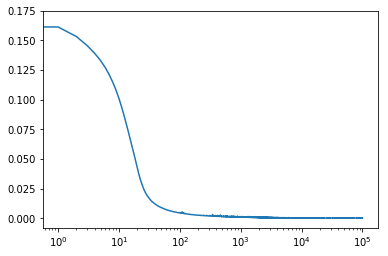

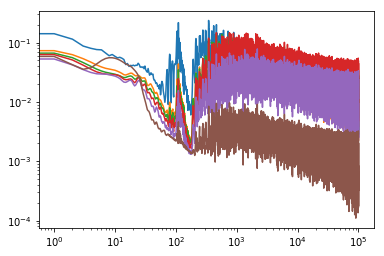

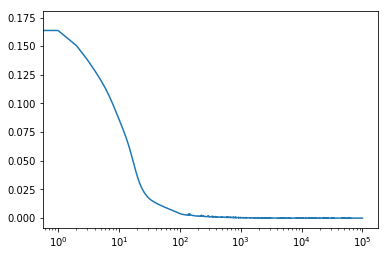

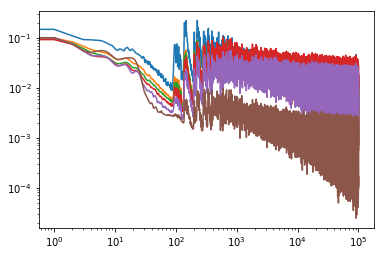

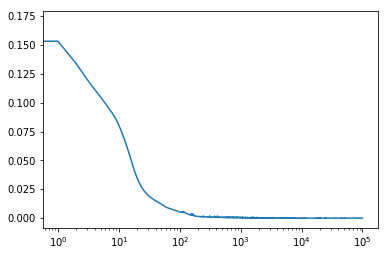

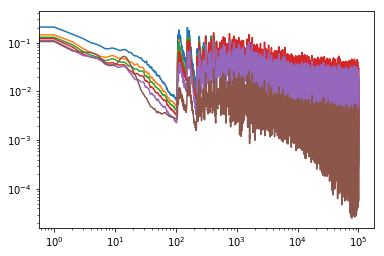

In [6]:
for (mse_n,mse_t,out_grads) in results_img:
    plt.semilogx(mse_n)
    plt.show()
    
    for g in out_grads:
        plt.loglog(g)
    plt.show()

## deep decoder - fit noise

In [7]:
img_noisy_np,img_noisy_var = get_noise()

results_noisy = []

for k in [128,256,512]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = decodernw(1,num_channels_up=num_channels).type(dtype)
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1
                        )
    results_noisy += [(mse_n,mse_t,out_grads)]

--------------- 128 ---------------
input shape:  [1, 128, 16, 16]
optimize with SGD 0.1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



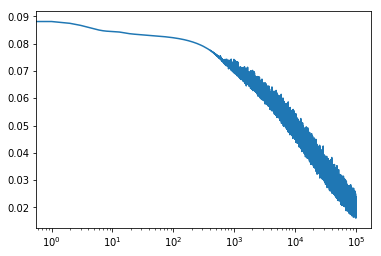

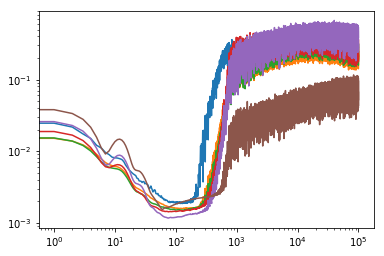

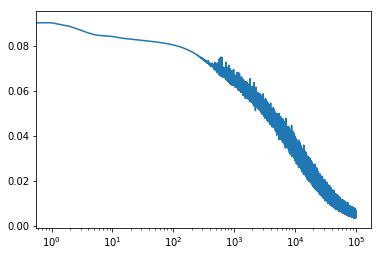

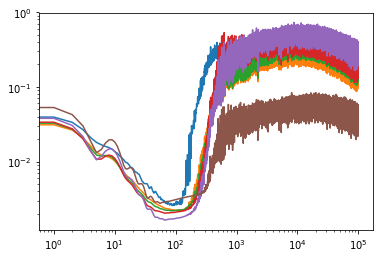

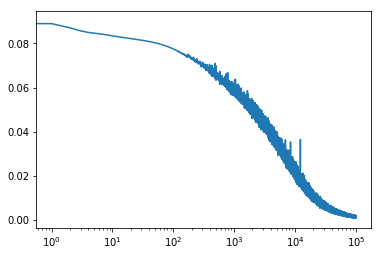

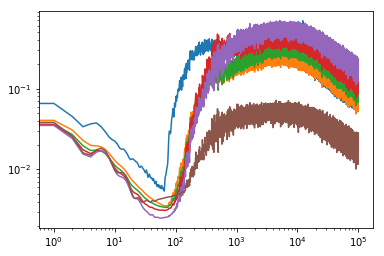

In [8]:
for (mse_n,mse_t,out_grads) in results_noisy:
    plt.semilogx(mse_n)
    plt.show()
    
    for g in out_grads:
        plt.loglog(g)
    plt.show()

## Fixed convolutions - simple image

In [ ]:
img_noisy_np,img_noisy_var = get_noisy_img(sig=0)

results_fixedimg = []

for k in [128,256,512]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = fixed_decodernw(output_depth,num_channels_up=num_channels).type(dtype)
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1,
                        upsample_mode = "none",
                        )
    
    results_fixedimg += [(mse_n,mse_t,out_grads)]

--------------- 128 ---------------
input shape:  [1, 128, 256, 256]
optimize with SGD 0.1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



--------------- 256 ---------------016  Actual loss 0.000016 Actual loss orig 0.000016 
input shape:  [1, 256, 256, 256]
optimize with SGD 0.1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



--------------- 512 ---------------004  Actual loss 0.000004 Actual loss orig 0.000004 
input shape:  [1, 512, 256, 256]
optimize with SGD 0.1


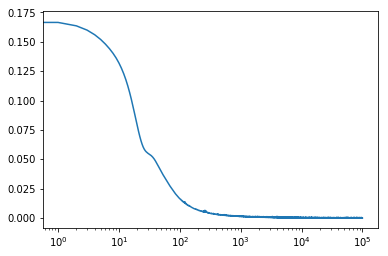

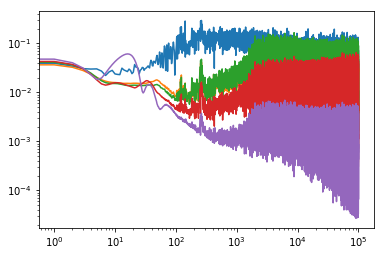

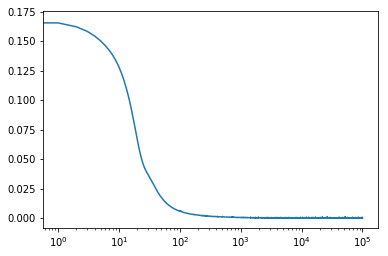

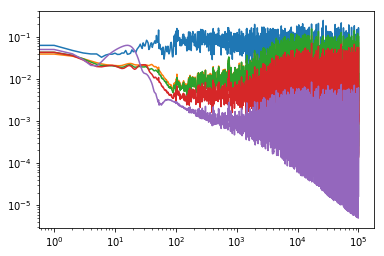

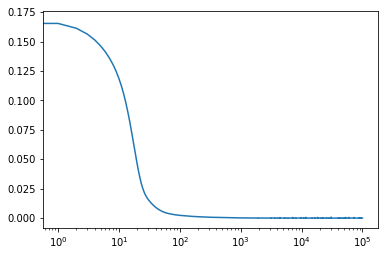

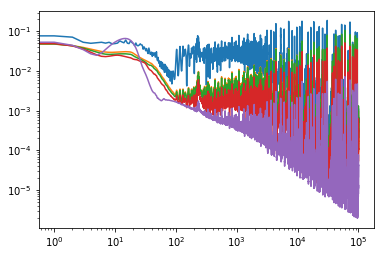

In [22]:
for (mse_n,mse_t,out_grads) in results_fixedimg:
    plt.semilogx(mse_n)
    plt.show()
    
    for g in out_grads:
        plt.loglog(g)
    plt.show()

## Fixed convolutions - noise

In [ ]:
img_noisy_np,img_noisy_var = get_noise()

results_fixednoise = []

for k in [128,256,512]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = fixed_decodernw(output_depth,num_channels_up=num_channels).type(dtype)
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1,
                        upsample_mode = "none",
                        )
    
    results_fixednoise += [(mse_n,mse_t,out_grads)]

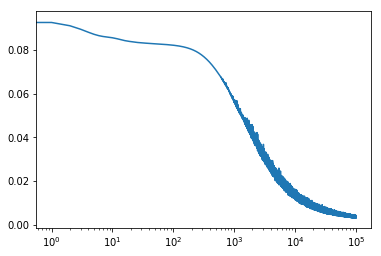

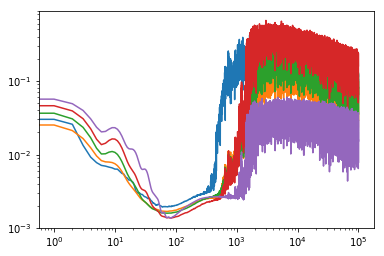

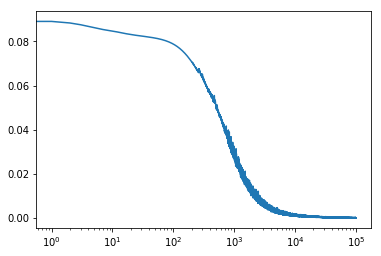

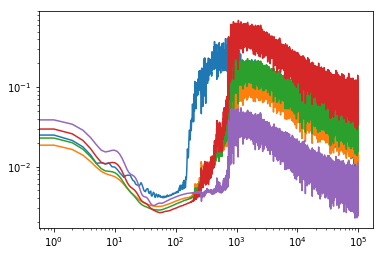

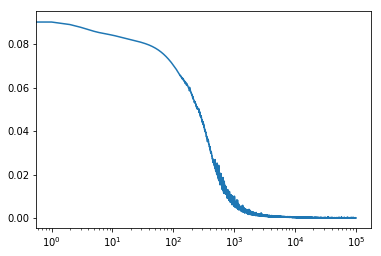

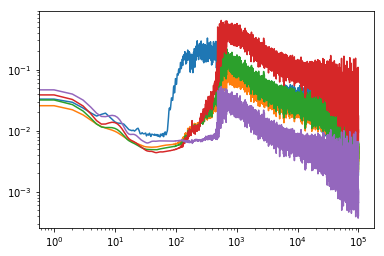

In [21]:
for (mse_n,mse_t,out_grads) in results_fixednoise:
    plt.semilogx(mse_n)
    plt.show()
    
    for g in out_grads:
        plt.loglog(g)
    plt.show()

## Trainable convolutions - simpe image

In [ ]:
img_noisy_np,img_noisy_var = get_noisy_img(sig=0)

results_learnedimg = []

for k in [42,85,170]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_mode='none',filter_size_up=3).type(dtype)
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1,
                        upsample_mode = "none",
                        )    
    results_learnedimg += [(mse_n,mse_t,out_grads)]

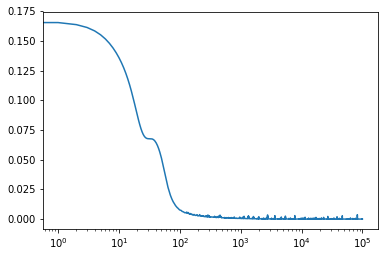

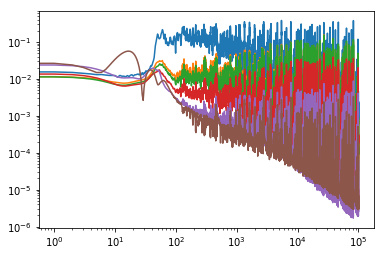

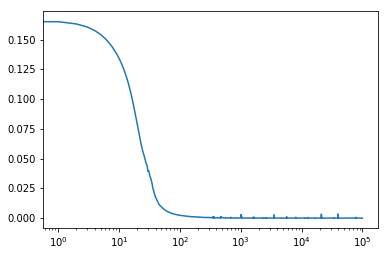

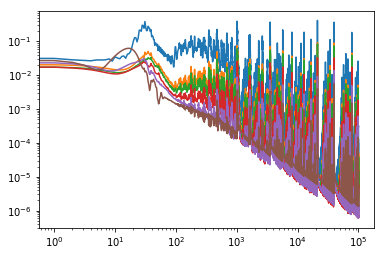

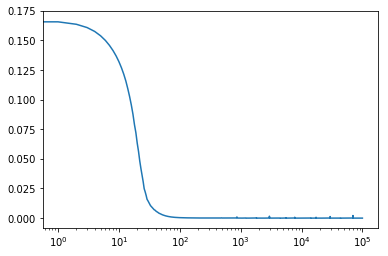

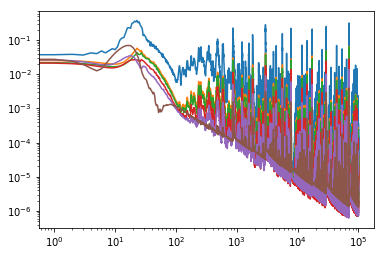

In [20]:
for (mse_n,mse_t,out_grads) in results_learnedimg:
    plt.semilogx(mse_n)
    plt.show()
    
    for g in out_grads:
        plt.loglog(g)
    plt.show()

## Trainable convolutions - noise

In [ ]:
img_noisy_np,img_noisy_var = get_noise()

results_ = []

results_learnednoise = []

for k in [42,85,170]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_mode='none',filter_size_up=3).type(dtype)
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1,
                        upsample_mode = "none",
                        )    
    results_learnednoise += [(mse_n,mse_t,out_grads)]

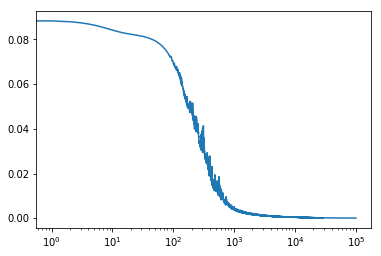

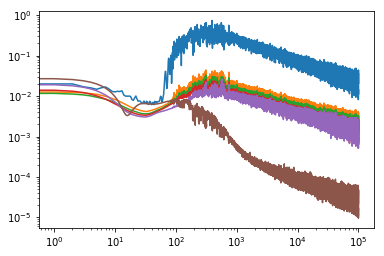

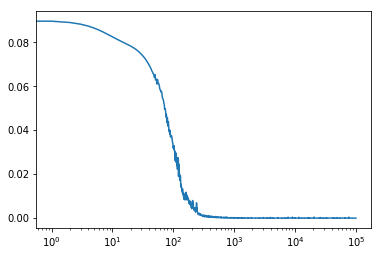

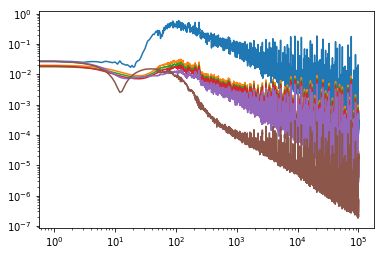

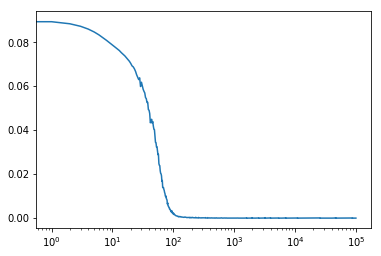

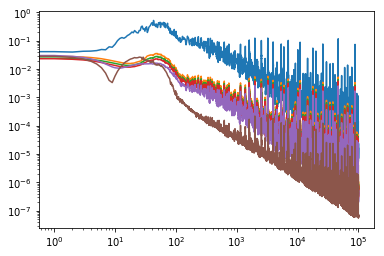

In [19]:
for (mse_n,mse_t,out_grads) in results_learnednoise:
    plt.semilogx(mse_n)
    plt.show()
    
    for g in out_grads:
        plt.loglog(g)
    plt.show()

## Devonvolution - image

In [15]:
img_noisy_np,img_noisy_var = get_noisy_img(sig=0)

results_deconv_img = []

for k in [42,85,170]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = deconv_decoder(1,num_channels_up=num_channels,filter_size=4,padding=1).type(dtype)
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1, upsample_mode="deconv"
                        )
    
    results_deconv_img += [(mse_n,mse_t,out_grads)]

--------------- 42 ---------------
input shape:  [1, 42, 32, 32]
optimize with SGD 0.1
--------------- 85 ---------------0001  Actual loss 0.000001 Actual loss orig 0.000001 
input shape:  [1, 85, 32, 32]
optimize with SGD 0.1
--------------- 170 ---------------000  Actual loss 0.000000 Actual loss orig 0.000000 
input shape:  [1, 170, 32, 32]
optimize with SGD 0.1


## Deconvolution - noise

In [22]:
img_noisy_np,img_noisy_var = get_noise()

results_ = []

results_deconv_noise = []

for k in [42,85,170]:
    print("---------------", k, "---------------")
    num_channels = [k]*4
    net = deconv_decoder(1,num_channels_up=num_channels,filter_size=4,padding=1).type(dtype)    
    mse_n, mse_t, ni, net, out_grads = fit( num_channels=num_channels,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        output_gradients=True,
                        OPTIMIZER = 'SGD', LR = 0.1,upsample_mode="deconv"
                        )
    results_deconv_noise += [(mse_n,mse_t,out_grads)]

--------------- 42 ---------------
input shape:  [1, 42, 32, 32]
optimize with SGD 0.1
--------------- 85 ---------------0056  Actual loss 0.245252 Actual loss orig 0.245252 
input shape:  [1, 85, 32, 32]
optimize with SGD 0.1
--------------- 170 ---------------000  Actual loss 0.245076 Actual loss orig 0.245076 
input shape:  [1, 170, 32, 32]
optimize with SGD 0.1


# Save results

In [18]:
def res_to_mtx(results,filename):
    ks = [10*i for i in range(len( results[0][0] )) ]
    A = [np.array(ks)]    
    for (mse_n,mse_t,out_grads) in results:
        A += [np.array(mse_n),np.array(mse_t)]
    A = np.vstack( A ).T
    savemtx_for_logplot(A.T,filename)

In [ ]:
res_to_mtx( results_img, "results_img.dat")
res_to_mtx( results_noisy, "results_noise.dat")

res_to_mtx( results_fixednoise, "results_fixednoise.dat")
res_to_mtx( results_fixedimg, "results_fixedimg.dat")

res_to_mtx( results_learnednoise, "results_learnednoise.dat")
res_to_mtx( results_learnedimg, "results_learnedimg.dat")

res_to_mtx( results_deconv_img, "results_deconv_img.dat")
res_to_mtx( results_deconv_noise, "results_deconv_noise.dat")